In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
from keras.utils import to_categorical  # Only for categorical one hot encoding
from tensorflow.keras import layers
from sklearn.metrics import accuracy_score
import tensorflow_datasets as tfds
import tensorflow_addons as tfa
from tensorflow.keras import backend as K

In [ ]:
lfw = tfds.load('lfw', split='train', shuffle_files=True)

Shuffling and writing examples to /root/tensorflow_datasets/lfw/0.1.0.incompleteBDNNSQ/lfw-train.tfrecord



Dataset lfw downloaded and prepared to /root/tensorflow_datasets/lfw/0.1.0. Subsequent calls will reuse this data.


In [ ]:
def plotImages(imgs):
    fig = plt.figure(figsize=(8, 8))
 
    for i in range(imgs.shape[0]):
      plt.subplot(8, 8, i+1)
      plt.imshow(tf.cast(imgs[i, :, :, :] * 127.5 + 127.5, tf.uint8))
      plt.axis('off')
    plt.show()

In [ ]:
def lerp(a, b, t):
    return a + (b - a) * t

def discriminator_loss(real_output, fake_output, smooth=1, wgan_target=1., wgan_lambda=10.):
    wgan_loss = tf.reduce_mean(fake_output) - tf.reduce_mean(real_output)
    return wgan_loss
    
def descriminator_WGANGPloss(reals, fakes, des, batch_size, smooth=1, wgan_target=1., wgan_lambda=10.):
    real_output = des(reals, training=True)
    fake_output = des(fakes, training=True)
    wgan_loss = discriminator_loss(real_output, fake_output)

    mixing_factors = tf.random.uniform([batch_size, 1, 1, 1], 0.0, 1.0, dtype=tf.float32)

    mixed_images = lerp(reals, fakes, mixing_factors)
    
    with tf.GradientTape() as gp_tape:
      gp_tape.watch(mixed_images)
      # 1. Get the discriminator output for this interpolated image.
      mixed_output = des(mixed_images, training=True)

    mixed_gradients = gp_tape.gradient(mixed_output, [mixed_images])[0]
    mixed_norms = tf.sqrt(tf.reduce_sum(tf.math.square(mixed_gradients), axis=[1,2,3]))
    gradient_penalty = tf.math.square(mixed_norms - wgan_target)
    total_loss = wgan_loss + (gradient_penalty * (wgan_lambda / (wgan_target**2)))
    return total_loss
 
def generator_loss(fake_output, smooth=1):
    total_loss = -tf.reduce_mean(fake_output)
    return total_loss
 
def generator_enc_loss(real, fake):
  # return tf.reduce_mean(tf.abs(real - fake))
  return tf.keras.losses.mean_absolute_error(real, fake)

In [ ]:
class PixelNorm(layers.Layer):
  def __init__(self, epsilon=1e-8):
    super(PixelNorm, self).__init__()
    self.epsilon = epsilon
  
  def call(self, x):
    return x * tf.math.rsqrt(tf.reduce_mean(tf.math.square(x), axis=3, keepdims=True) + self.epsilon)

class FadeAdd(layers.Layer):
  def __init__(self):
    super(FadeAdd, self).__init__()
    self.alpha = tf.Variable(initial_value=0., trainable=False)
 
  def incrementAlpha(self, step=0.1):
    self.alpha.assign(tf.minimum(self.alpha+step, 1.))
    # print("New Alpha: ", self.alpha)
 
  def call(self, input):
    new, old = input
    self.alpha.assign(tf.minimum(self.alpha, 1.))
    return (new*self.alpha) + (old*(1-self.alpha))

class MinibatchStddev(layers.Layer):
  def __init__(self, group_size=4):
    super(MinibatchStddev, self).__init__()
    self.group_size = group_size

  def call(self, layer):
    group_size = tf.minimum(self.group_size, tf.shape(layer)[0])
    shape = tf.shape(layer)
    minibatch = tf.reshape(layer,(group_size, -1, shape[1], shape[2], shape[3]))
    minibatch -= tf.reduce_mean(minibatch, axis=0, keepdims=True)
    minibatch = tf.reduce_mean(tf.math.square(minibatch), axis = 0)
    minibatch = tf.math.sqrt(minibatch + 1e8)
    minibatch = tf.reduce_mean(minibatch, axis=[1,2, 3], keepdims=True)
    minibatch = tf.tile(minibatch,[group_size, shape[1], shape[2], 1]) 
    return K.concatenate([layer, minibatch], axis=3)          # NHW1

def generatorBase():
  inputLayer = layers.Input((512))
  x = layers.Dense(4*4*128, use_bias=True, kernel_initializer=tf.keras.initializers.HeNormal())(inputLayer)
  x = layers.BatchNormalization(momentum=0.8)(x)
  x = layers.LeakyReLU(alpha=0.2)(x)
  x = layers.Reshape((4, 4, 128))(x)
  # x = PixelNorm()(x)

  # x = tf.keras.layers.UpSampling2D()(x)
  x = tf.keras.layers.GaussianNoise(0.5)(x)

  # x = layers.Conv2D(256, kernel_size=(3, 3), padding='same')(x)
  # x = layers.BatchNormalization(momentum=0.8)(x)
  # x = layers.LeakyReLU()(x)

  x = layers.Conv2D(256, kernel_size=(3, 3), padding='same', kernel_initializer=tf.keras.initializers.HeNormal())(x)
  x = layers.BatchNormalization(momentum=0.8)(x)
  x = layers.LeakyReLU(name='final_4')(x)
  # x = PixelNorm()(x)

  x = tf.keras.layers.GaussianNoise(0.1)(x)
 
  out = layers.Conv2D(3, (4, 4), strides=(1, 1), padding='same', use_bias=True, activation='tanh', name='out_4', kernel_initializer=tf.keras.initializers.HeNormal())(x)
  print(out.shape)
  model = tf.keras.models.Model(inputs=inputLayer, outputs=out)
  return model
 
def generatorAddStage(gen, newDepth=0, freeze=False, initialAlpha=0):
  print("Current Shape: ", gen.output.shape)
 
  if freeze:
    print("Freezing")
    gen.trainable = False
 
  lastSize = gen.output.shape[1]
  x = gen.get_layer('final_'+str(lastSize)).output
  print("Choosing layer ", x)
 
  shape = x.shape
 
  if newDepth == 0:
    newDepth = shape[3] // 2
 
  print("New Depth: ", newDepth)
  
  # x = layers.Conv2DTranspose(newDepth, (5, 5), strides=(2, 2), padding='same', use_bias=False)(x)
  x = layers.UpSampling2D(size=(2,2), interpolation='nearest')(x)

  x = layers.Conv2D(newDepth, (3, 3), strides=(1, 1), padding='same', use_bias=True, kernel_initializer=tf.keras.initializers.HeNormal())(x)
  x = layers.BatchNormalization(momentum=0.8)(x)
  x = layers.LeakyReLU()(x)
  # x = PixelNorm()(x)

  x = layers.Conv2D(newDepth, (3, 3), strides=(1, 1), padding='same', use_bias=True, kernel_initializer=tf.keras.initializers.HeNormal())(x)
  x = layers.BatchNormalization(momentum=0.8)(x)
  x = layers.LeakyReLU(name='final_'+str(lastSize*2))(x)
  # x = PixelNorm()(x)
 
  # x = tf.keras.layers.GaussianNoise(0.3)(x)

  # out = layers.Conv2DTranspose(3, (7, 7), strides=(2, 2), padding='same', use_bias=False, activation='tanh')(out)
  out = layers.Conv2D(3, (4, 4), strides=(1, 1), padding='same', use_bias=True, activation='tanh', name='out_'+str(lastSize*2), kernel_initializer=tf.keras.initializers.HeNormal())(x)
  print("New Shape: ", out.shape)
 
  # Add prev output
  lastOut = gen.get_layer('out_'+str(lastSize)).output
  up = layers.UpSampling2D((2,2), interpolation='nearest')(lastOut)
 
  alpha = FadeAdd()
  out = alpha([out, up])
 
  inputLayer = gen.input
  model = tf.keras.models.Model(inputs=inputLayer, outputs=out)
  return model, alpha
 
def changeGenAlpha(gen, alpha, step=0.1):
  newAlpha = alpha + step
  out = gen.layers[-1]
 
def reBaseModel(layers, inpTensor):
  layer = inpTensor
  # print("Rebasing")
  for i in range(len(layers)):
    # print(layer)
    layer = layers[i](layer)
  # print("Done")
  return layer
 
def descriminatorBase():
  inputLayer = layers.Input((4, 4, 3))
  x = tf.keras.layers.GaussianNoise(0.07)(inputLayer)

  x = tf.keras.layers.Conv2D(256, (1, 1), padding='same', name='sup_conv_256', kernel_initializer=tf.keras.initializers.HeNormal())(x)
  x = tf.keras.layers.BatchNormalization(name='sup_bn_256')(x)
  x = tf.keras.layers.LeakyReLU(name='sup_act_256')(x)

  # x = reBaseModel(processingLayers, x)
 
  baseLayers = []
  baseLayers.append(MinibatchStddev())
  # baseLayers.append(layers.Conv2D(512, (3, 3), strides=(1, 1), padding='same'))
  baseLayers.append(layers.Conv2D(512, kernel_size=(3, 3), strides=(1, 1), padding='same', name='depth_512', kernel_initializer=tf.keras.initializers.HeNormal()))
  # baseLayers.append(layers.Conv2D(512, kernel_size=(3, 3), strides=(1, 1), padding='same', name='depth_512'))
  # baseLayers.append(layers.DepthwiseConv2D(depth_multiplier=2, kernel_size=(4, 4), strides=(1, 1), padding='same', name='depth_512'))
  baseLayers.append(layers.BatchNormalization(momentum=0.8))
  baseLayers.append(layers.LeakyReLU())
 
  baseLayers.append(layers.GlobalAveragePooling2D())
  baseLayers.append(layers.Dense(1, kernel_initializer=tf.keras.initializers.HeNormal()))
 
  encOut = reBaseModel(baseLayers[:-1], x)
  desOut = reBaseModel(baseLayers, x)
 
  dis = tf.keras.models.Model(inputs=inputLayer, outputs=desOut)
  enc = tf.keras.models.Model(inputs=inputLayer, outputs=encOut)
  return dis, enc, baseLayers
 
def descriminatorAddStage(des, enc, baseLayers, newDepth=0, newSize=0, freeze=False):
  print("Current Shape: ", enc.input.shape)
 
  if freeze:
    print("Freezing")
    des.trainable = False
    enc.trainable = False
 
  print("Previous Input layer ", enc.input)
 
  if newDepth == 0:
    # newDepth = enc.layers[5].output.shape[3] // 2
    for layer in enc.layers:
      if 'depth_' in layer.name:
        newDepth = layer.output.shape[3]//2
        print("New Depth: ", newDepth)
        break
        
  if newSize == 0:
    newSize = enc.input.shape[2] * 2
 
  print("New input ", newSize, newSize)
 
  inputLayer = layers.Input((newSize, newSize, 3))
  inp = tf.keras.layers.GaussianNoise(0.07)(inputLayer) 

  processingLayers = []
  processingLayers.append(tf.keras.layers.Conv2D(newDepth // 2, (1, 1), padding='same', name='sup_conv_'+str(newDepth//2), kernel_initializer=tf.keras.initializers.HeNormal()))
  processingLayers.append(tf.keras.layers.BatchNormalization(name='sup_bn_'+str(newDepth//2)))
  processingLayers.append(tf.keras.layers.LeakyReLU(name='sup_act_'+str(newDepth//2)))
  
  x = reBaseModel(processingLayers, inp)

  newLayers = []
  newLayers.append(layers.Conv2D(newDepth, (3, 3), strides=(1, 1), padding='same', name='depth_'+str(newDepth), kernel_initializer=tf.keras.initializers.HeNormal()))
  newLayers.append(layers.BatchNormalization(momentum=0.8))
  newLayers.append(layers.LeakyReLU())
  newLayers.append(layers.Conv2D(newDepth, (3, 3), strides=(1, 1), padding='same', name='depth2_'+str(newDepth), kernel_initializer=tf.keras.initializers.HeNormal()))
  newLayers.append(layers.BatchNormalization(momentum=0.8))
  newLayers.append(layers.LeakyReLU())
  newLayers.append(layers.AveragePooling2D())
  
  newInp = reBaseModel(newLayers, x)
  # print(newInp, baseLayers)
 
  small = layers.AveragePooling2D((2, 2))(inp)
  sup = des.get_layer('sup_conv_'+str(newDepth))(small)
  sup = des.get_layer('sup_bn_'+str(newDepth))(sup)
  sup = des.get_layer('sup_act_'+str(newDepth))(sup)

  print("====>", sup)
 
  print(newInp.shape, sup.shape)
  beta = FadeAdd()
  out = beta([newInp, sup])

  print("==>", out)
 
  desOut = reBaseModel(baseLayers, out)
  encOut = reBaseModel(baseLayers[:-1], out)
 
  des = tf.keras.models.Model(inputs=inputLayer, outputs=desOut)
  enc = tf.keras.models.Model(inputs=inputLayer, outputs=encOut)
 
  baseLayers = newLayers + baseLayers
  return des, enc, baseLayers, beta
 
def generateBaseModels():
  gen = generatorBase()
  des, enc, baseLayers = descriminatorBase()
  return gen, des, enc, baseLayers

In [ ]:
gen, des, enc, baseLayers = generateBaseModels()

(None, 4, 4, 3)


In [ ]:
gen, alpha = generatorAddStage(gen, False)

Current Shape:  (None, 16, 16, 3)
Choosing layer  Tensor("final_16/LeakyRelu:0", shape=(None, 16, 16, 64), dtype=float32)
New Depth:  32
New Shape:  (None, 32, 32, 3)


In [ ]:
des, enc, baseLayers, beta = descriminatorAddStage(des, enc, baseLayers)

Current Shape:  (None, 8, 8, 3)
Previous Input layer  Tensor("input_3:0", shape=(None, 8, 8, 3), dtype=float32)
New Depth:  128
New input  16 16
====> Tensor("sup_act_128/LeakyRelu_1:0", shape=(None, 8, 8, 128), dtype=float32)
(None, 8, 8, 128) (None, 8, 8, 128)
==> Tensor("fade_add_4/add:0", shape=(None, 8, 8, 128), dtype=float32)


In [ ]:
# gen = generator()
# des, enc, cls = discriminator()
 
generator_optimizer = tfa.optimizers.Lookahead(tf.keras.optimizers.Adam(1e-4))
discriminator_optimizer = tfa.optimizers.Lookahead(tf.keras.optimizers.Adam(1e-4))
enc_optimizer = tfa.optimizers.Lookahead(tf.keras.optimizers.Adam(3e-4))

In [ ]:
# @tf.function
def trainGenEnc(gen, enc, real, batch_size, coeff=1):
  with tf.GradientTape() as enc_tape, tf.GradientTape() as gen_tape:
    real_enc = enc(real, training=True)
    enc_fake = gen(real_enc, training=True)
 
    gen_loss = generator_enc_loss(real, enc_fake) * coeff
    gradients_of_generator = gen_tape.gradient(gen_loss, gen.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, gen.trainable_variables))
 
    gradients_of_enc = enc_tape.gradient(gen_loss, enc.trainable_variables)
    enc_optimizer.apply_gradients(zip(gradients_of_enc, enc.trainable_variables))
 
# @tf.function
def trainDes(gen, des, real, batch_size, smooth):
  with tf.GradientTape() as disc_tape:
    noise = tf.random.normal([batch_size, 512])
 
    fake = gen(noise, training=False)
    
    des_loss = descriminator_WGANGPloss(real, fake, des, batch_size)

    gradients_of_discriminator = disc_tape.gradient(des_loss, des.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, des.trainable_variables))
 
# @tf.function
def trainDesGen(gen, des, real, batch_size, smooth):
  with tf.GradientTape() as disc_tape, tf.GradientTape() as gen_tape:
    noise = tf.random.normal([batch_size, 512])
    fake = gen(noise, training=True)
    
    fake_output = des(fake, training=True)

    des_loss = descriminator_WGANGPloss(real, fake, des, batch_size)
    gen_loss = generator_loss(fake_output, smooth)
 
    gradients_of_discriminator = disc_tape.gradient(des_loss, des.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, des.trainable_variables))
 
    gradients_of_generator = gen_tape.gradient(gen_loss, gen.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, gen.trainable_variables))
 
# @tf.function
def trainGen(gen, des, batch_size, smooth):
  with tf.GradientTape() as gen_tape:
    noise = tf.random.normal([batch_size, 512])
 
    fake = gen(noise, training=True)
    fake_output = des(fake, training=False)
 
    gen_loss = generator_loss(fake_output, smooth)
 
    gradients_of_generator = gen_tape.gradient(gen_loss, gen.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, gen.trainable_variables))
 
def evalGan(gen, des, data, batches, batch_size):
  desAcc = 0
  genLoss = 0
  for i in range(batches):
    real = data
    fake = gen.predict(tf.random.normal([batch_size, 512]))
    X = tf.concat((fake, real), axis=0)
 
    output = des.predict(X)
 
    real_output = output[batch_size:]
    fake_output = output[:batch_size]
 
    labels = tf.reshape(tf.concat((tf.zeros_like(fake_output), tf.ones_like(real_output)), axis=0), [-1])
    output = tf.reshape(output, [-1])
    
    acc = tf.keras.metrics.binary_accuracy(labels, output, threshold=0.5)
    desAcc += acc.numpy()
    # print(acc)
    genLoss += tf.reduce_sum(generator_loss(fake_output, 1)).numpy() / batch_size
  return desAcc / batches, genLoss / batches
 
def augmenter(size):
  def augment(sample):
    sample['image'] = tf.image.resize(sample['image'], [size, size], method='nearest', antialias=True)
    return sample
  return augment

from IPython.display import clear_output

def trainGan(data, epochs=10, batch_size=5, loss='mse', smooth=1., sizes=[4, 8, 16, 32, 64, 128, 256]):
  global gen, des, enc, baseLayers
  realData = data
  # print(realData.shape)
  noise = tf.random.normal([64, 512])
  results = []
  gen_alpha, des_alpha = None, None
  initialCoeff = 1.
  for size in sizes:
    coeff = initialCoeff
    print("Input shape: ",des.input.shape)
    currentData = realData.map(augmenter(size)).batch(batch_size, drop_remainder=True).shuffle(4096).prefetch(tf.data.experimental.AUTOTUNE)
    for epoch in range(epochs):
      b = 0
      for batch in currentData:
        b += 1
        if des_alpha != None and gen_alpha != None:
          des_alpha.incrementAlpha(0.1 / ((220*60)/batch_size))
          gen_alpha.incrementAlpha(0.1 / ((220*60)/batch_size))

        real = batch['image']
        real = (tf.cast(real, tf.float32) - 127.5) / 127.5
 
        trainDes(gen, des, real, batch_size, smooth)
        trainDes(gen, des, real, batch_size, smooth)
        trainGen(gen, des, batch_size, smooth)
        trainDesGen(gen, des, real, batch_size, smooth)
        if coeff >= 0.15:
          trainGenEnc(gen, enc, real, batch_size, coeff)
        # else:
        #   trainGenEnc(gen, enc, real, batch_size, 0.15)
        # trainDesGenEnc(gen, des, enc, real, batch_size)

      coeff *= 0.9

      fake = gen.predict(noise)
      print("Evaluating:")
      desAcc, genLoss = evalGan(gen, des, real, 10, batch_size)
      results.append({'desAcc':desAcc, 'genLoss':genLoss})
      print("Epoch ", epoch, desAcc, genLoss, "of ", epochs, "Epochs")

      print("epoch length: ", b)
      print("Real: ")
      plotImages(real)
 
      print("Fake: ")
      plotImages(fake)

      if desAcc > 0.8:
        coeff *= 2
        coeff = min(coeff, 1.)

      if des_alpha != None and gen_alpha != None:
        print("Alpha, Beta: ", gen_alpha.alpha, des_alpha.alpha)

    des, enc, baseLayers, des_alpha = descriminatorAddStage(des, enc, baseLayers, freeze=False)
    gen, gen_alpha = generatorAddStage(gen, freeze=False)
    epochs *= 1.6
    epochs = int(epochs)
    initialCoeff *= 0.6
    clear_output(wait=True)

(None, 4, 4, 3)
Input shape:  (None, 4, 4, 3)
Evaluating:
Epoch  0 0.465625 -0.007686419598758221 of  10 Epochs
epoch length:  206
Real: 


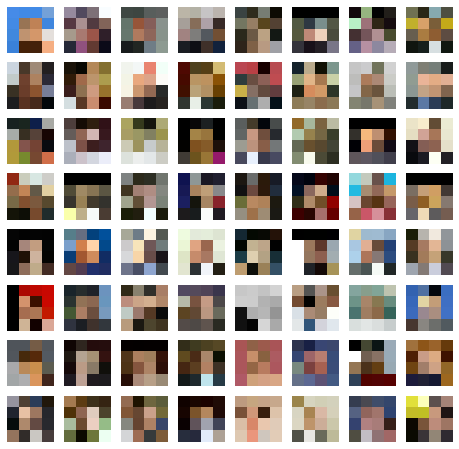

Fake: 


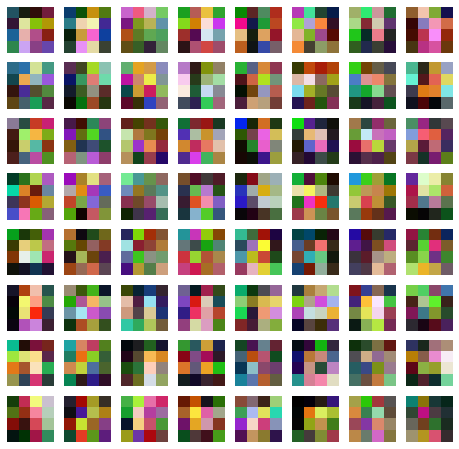

Evaluating:
Epoch  1 0.4640625 -0.0127231540158391 of  10 Epochs
epoch length:  206
Real: 


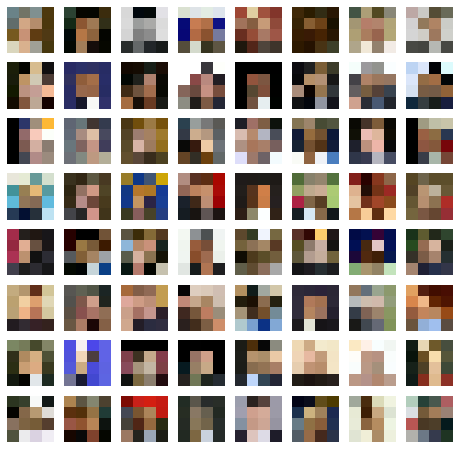

Fake: 


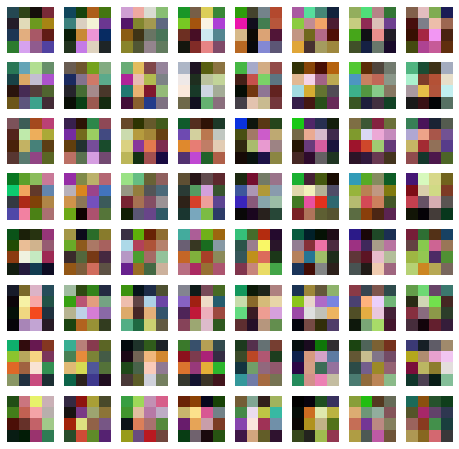

Evaluating:
Epoch  2 0.48046875 -0.02463642805814743 of  10 Epochs
epoch length:  206
Real: 


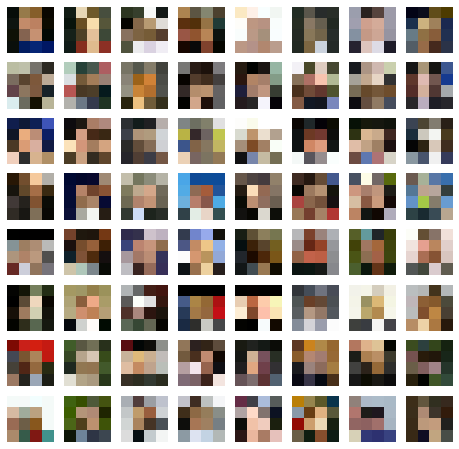

Fake: 


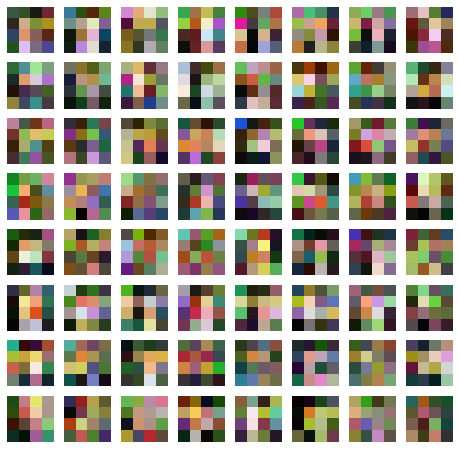

Evaluating:
Epoch  3 0.5 -0.0299123153090477 of  10 Epochs
epoch length:  206
Real: 


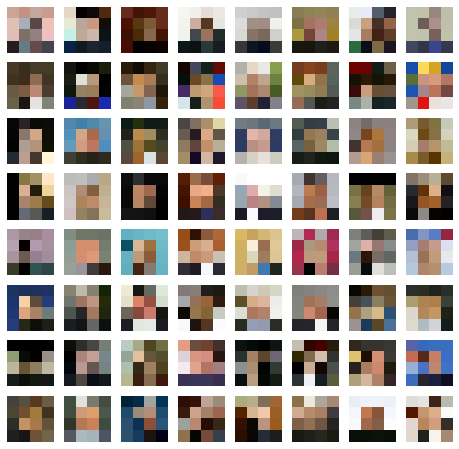

Fake: 


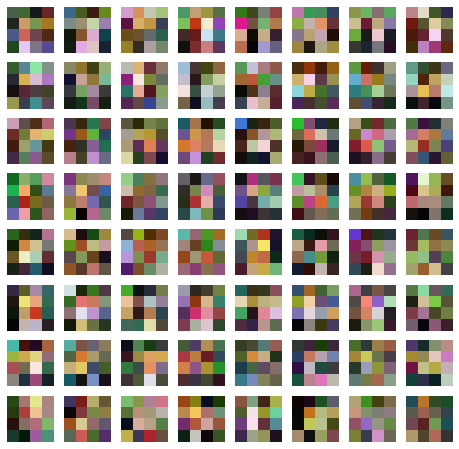

Evaluating:
Epoch  4 0.484375 -0.02628666441887617 of  10 Epochs
epoch length:  206
Real: 


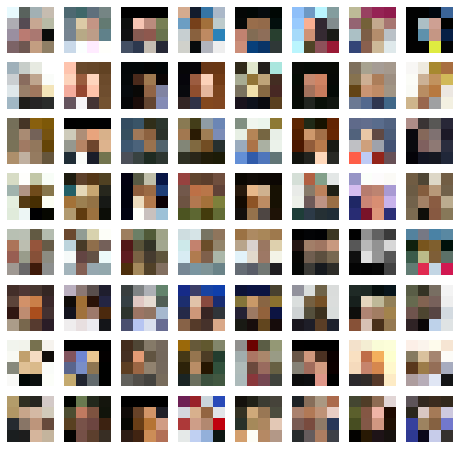

Fake: 


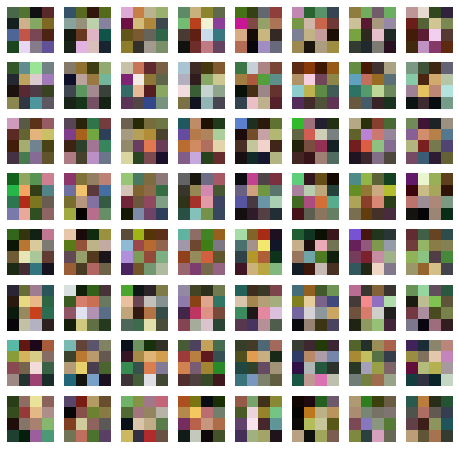

KeyboardInterrupt: ignored

In [ ]:
global gen, des, enc, baseLayers
gen, des, enc, baseLayers = generateBaseModels()
trainGan(lfw, epochs=10, batch_size=64, smooth=1)

In [ ]:
1